In [22]:
import os
os.chdir('/root/myWorkPlace/MTSDM/MTSDM')
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import data.C_MAPSS.CMAPSSDataset as CMAPSSDataset
from ydata_synthetic.synthesizers.timeseries import TimeGAN

In [23]:
seq_len = 48        # Timesteps
n_seq = 14          # Features
hidden_dim = 24
gamma = 1           
noise_dim = 32      
dim = 128           # UNUSED
batch_size = 128
learning_rate = 5e-4
beta_1 = 0          # UNUSED
beta_2 = 1          # UNUSED
data_dim = 28       # UNUSED

# batch_size, lr, beta_1, beta_2, noise_dim, data_dim, layers_dim
gan_args = [batch_size, learning_rate, beta_1, beta_2, noise_dim, data_dim, dim]


In [24]:
from ydata_synthetic.preprocessing.timeseries.utils import real_data_loading

file_path = r"data/energy_data/energy_data.csv"
energy_df = pd.read_csv(file_path)

print(energy_df.head(5))

try:
    energy_df = energy_df.set_index('Date').sort_index()
except:
    energy_df = energy_df

# Data transformations to be applied prior to be used with the synthesizer model
energy_data = real_data_loading(energy_df.values, seq_len=seq_len)

print(len(energy_data), energy_data[0].shape)

   Appliances  lights     T1       RH_1    T2       RH_2     T3       RH_3  \
0          60      30  19.89  47.596667  19.2  44.790000  19.79  44.730000   
1          60      30  19.89  46.693333  19.2  44.722500  19.79  44.790000   
2          50      30  19.89  46.300000  19.2  44.626667  19.79  44.933333   
3          50      40  19.89  46.066667  19.2  44.590000  19.79  45.000000   
4          60      40  19.89  46.333333  19.2  44.530000  19.79  45.000000   

          T4       RH_4  ...         T9   RH_9     T_out  Press_mm_hg  RH_out  \
0  19.000000  45.566667  ...  17.033333  45.53  6.600000        733.5    92.0   
1  19.000000  45.992500  ...  17.066667  45.56  6.483333        733.6    92.0   
2  18.926667  45.890000  ...  17.000000  45.50  6.366667        733.7    92.0   
3  18.890000  45.723333  ...  17.000000  45.40  6.250000        733.8    92.0   
4  18.890000  45.530000  ...  17.000000  45.40  6.133333        733.9    92.0   

   Windspeed  Visibility  Tdewpoint        r

In [25]:
datasets = CMAPSSDataset.CMAPSSDataset(fd_number='FD001', sequence_length=48 ,deleted_engine=[1000])
train_data = datasets.get_train_data()
train_data,train_label = datasets.get_sensor_slice(train_data), datasets.get_label_slice(train_data)  
print(train_data.shape)

torch.Size([15931, 48, 14])


In [26]:
if path.exists('/root/myWorkPlace/MTSDM/MTSDM/model/TimeGan/models/synth_energy.pkl'):
    synth = TimeGAN.load('/root/myWorkPlace/MTSDM/MTSDM/model/TimeGan/models/synth_energy.pkl')
else:
    synth = TimeGAN(model_parameters=gan_args, hidden_dim=hidden_dim, seq_len=seq_len, n_seq=n_seq, gamma=1)
    synth.train(train_data, train_steps=500)
    synth.save('/root/myWorkPlace/MTSDM/MTSDM/model/TimeGan/models/synth_energy.pkl')

Joint networks training: 100%|██████████| 500/500 [14:10<00:00,  1.70s/it]


In [27]:
synth_data = synth.sample(len(train_data))
print(synth_data.shape)

Synthetic data generation: 100%|██████████| 125/125 [00:39<00:00,  3.17it/s]

(16000, 48, 14)


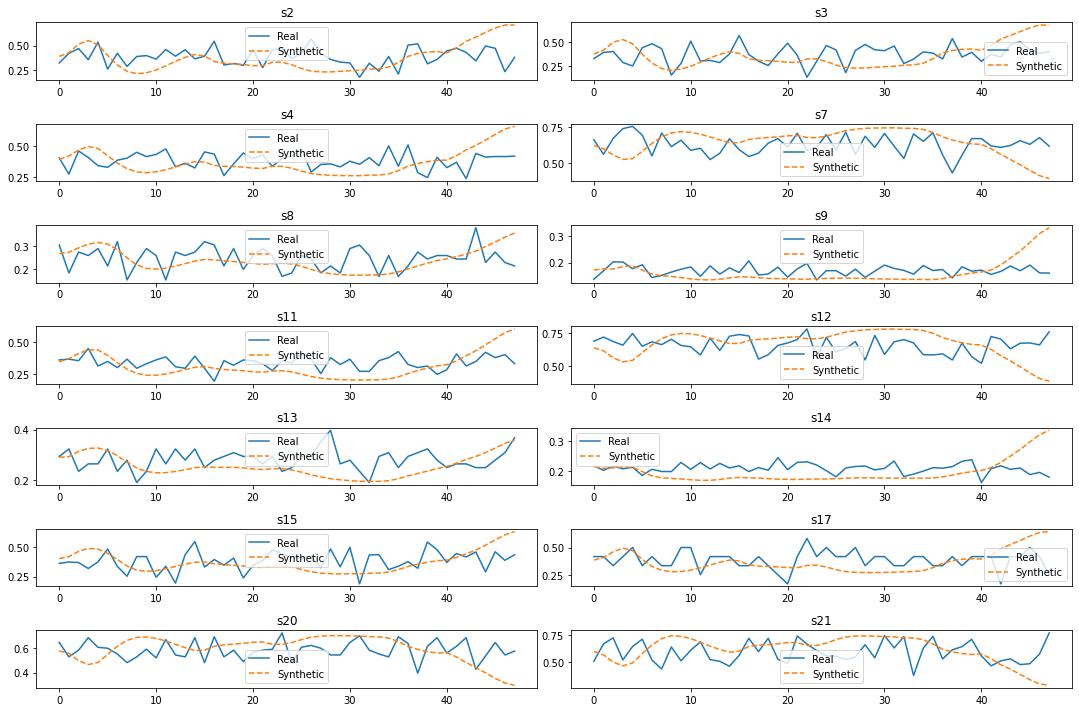

In [28]:
cols = ['s2', 's3','s4',  's7', 's8', 's9',  's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']

# Plotting some generated samples. Both Synthetic and Original data are still standardized with values between [0, 1]
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15, 10))
axes=axes.flatten()

time = list(range(1,15))
obs = np.random.randint(len(train_data))

for j, col in enumerate(cols):
    df = pd.DataFrame({'Real': train_data[obs][:, j],
                   'Synthetic': synth_data[obs][:, j]})
    df.plot(ax=axes[j],
            title = col,
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()

if not os.path.exists("/root/myWorkPlace/MTSDM/MTSDM/model/TimeGan/img"):
    os.makedirs("/root/myWorkPlace/MTSDM/MTSDM/model/TimeGan/img")
plt.savefig('/root/myWorkPlace/MTSDM/MTSDM/model/TimeGan/img/comparison_gan_outputs.png', dpi=200)

In [29]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sample_size = 250
idx = np.random.permutation(len(train_data))[:sample_size]

# Convert list to array, but taking only 250 random samples
# energy_data: (list(19711(ndarray(24, 28)))) -> real_sample: ndarray(250, 24, 28)
real_sample = np.asarray(train_data)[idx]
synthetic_sample = np.asarray(synth_data)[idx]

# For the purpose of comparison we need the data to be 2-Dimensional.
# For that reason we are going to use only two components for both the PCA and TSNE.
# synth_data_reduced: {ndarray: (7000, 24)}
# energy_data_reduced: {ndarray: (7000, 24)}
synth_data_reduced = real_sample.reshape(-1, seq_len)
train_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

# The fit of the methods must be done only using the real sequential data
pca.fit(train_data_reduced)

# pca_real: {DataFrame: (7000, 2)}
# pca_synth: {DataFrame: (7000, 2)}
pca_real = pd.DataFrame(pca.transform(train_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

# data_reduced: {ndarray: (14000, 24)}
data_reduced = np.concatenate((train_data_reduced, synth_data_reduced), axis=0)

# tsne_results: {DataFrame: (14000, 2)}
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

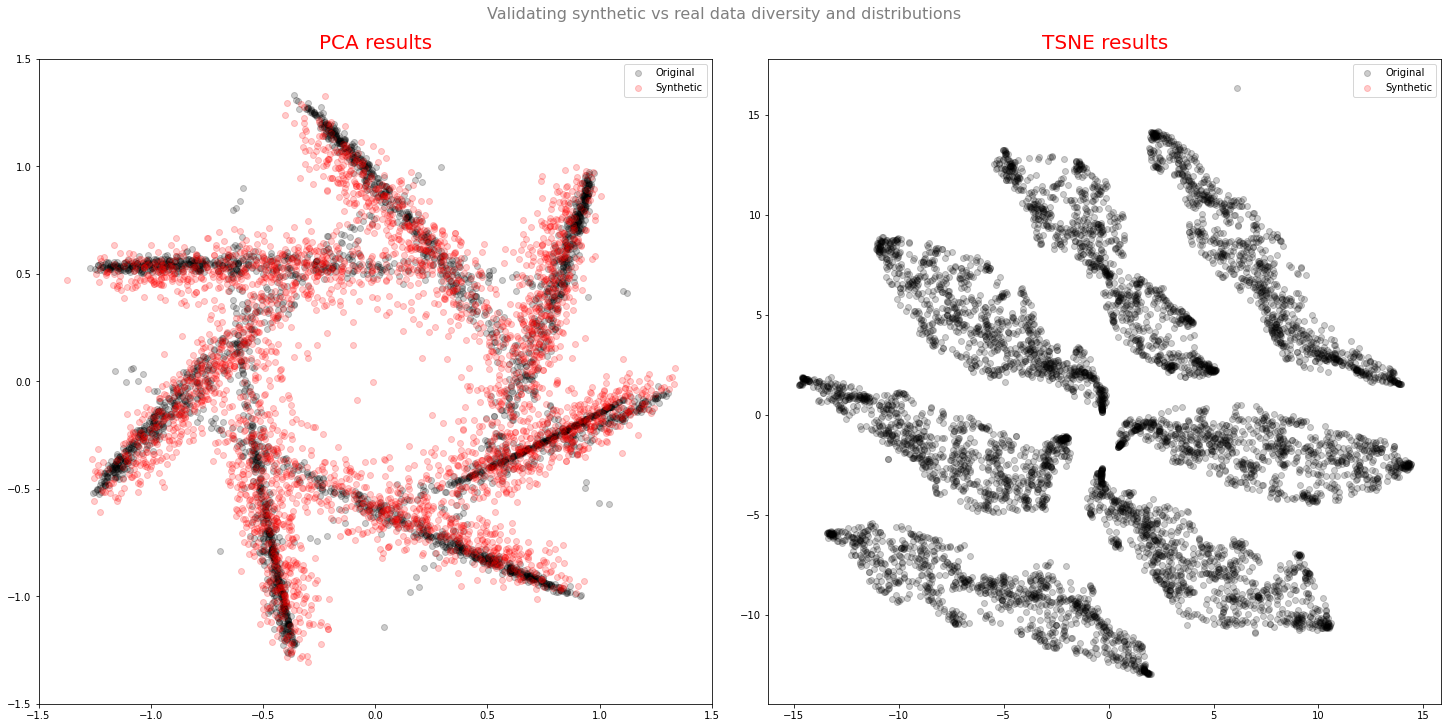

In [30]:
# Scatter plots for PCA and t-SNE methods

import matplotlib.gridspec as gridspec

fig = plt.figure(constrained_layout=True, figsize=(20, 10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

# PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:, 1].values,
            c='black', alpha=0.2, label='Original')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

plt.scatter(pca_synth.iloc[:, 0], pca_synth.iloc[:, 1],
            c='red', alpha=0.2, label='Synthetic')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

# t-SNE scatter plot
plt.scatter(tsne_results.iloc[:7000, 0].values, tsne_results.iloc[:7000, 1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[7000:, 0], tsne_results.iloc[7000:, 1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')

if not os.path.exists("/root/myWorkPlace/MTSDM/MTSDM/model/TimeGan/img"):
    os.makedirs("/root/myWorkPlace/MTSDM/MTSDM/model/TimeGan/img")
plt.savefig('/root/myWorkPlace/MTSDM/MTSDM/model/TimeGan/img/synthetic_vs_real_data_diversity_and_distributions.png', dpi=200)